# Bayesian filtering: continuous case optimized

## Create the data structures and functions

Load the libraries we need

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy import integrate
from scipy import misc
import matplotlib.pyplot as plt
import math
import time

Define the state variables $\mathbf{X}$ and the sensor variables $\mathbf{Y}$. In this case, the state variables consist of the $x$ and $y$ positions of the object and the sensor variables are the distances to the object measured by sensors in the four corners of a square: lower left, upper left, lower right, and upper right.

In [2]:
x_names = [
    'pos_x',
    'pos_y'
]

x_names_long = [
    '$x$ position',
    '$y$ position'
]

y_names = [
    'LL',
    'UL',
    'LR',
    'UR'
]

y_names_long = [
    'Lower left',
    'Upper left',
    'Lower right',
    'Upper right'
]

In [3]:
num_x_vars = len(x_names)
num_y_vars = len(y_names)

Define the parameters of the initial state, the transition model and the sensor response model. In this case, the initial state is a two-dimensional Gaussian with mean of $(0,0)$ and a standard deviation of $\sigma_i = 0.1$. The transition model is a two-dimensional Gaussian random walk with a standard deviation of $\sigma_t = 0.1$. The sensor response model is that the sensors are placed at $(-1, -1)$, $(-1, 1)$, $(1, -1)$, and $(1, 1)$ and they measure the distance to the object with Gaussian error $\sigma_m = 0.2$.

In [4]:
initial_position = np.array([0.0, 0.0])
initial_error = 0.1
drift = 0.1
sensor_positions = np.array([
    [-1.0, -1.0],
    [-1.0, 1.0],
    [1.0, -1.0],
    [1.0, 1.0]
])
sensor_error = 0.2

Define a function that generates samples of the initial state $\mathbf{X}_0$. We use the multivariate normal sampling function from the `numpy` package rather than the one from the `scipy` package just for simplicity. They seemed to perform similarly in our tests.

In [5]:
initial_covariance = np.diagflat(np.repeat(initial_error**2, 2))

In [6]:
def x_initial_sample():
    return np.random.multivariate_normal(initial_position, initial_covariance)

Generate 1,000 samples and check that they have the properties we expect.

In [7]:
time_start = time.clock()
x_initial_samples = np.array([x_initial_sample() for i in range(1000)])
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 0.156940733039


In [8]:
np.mean(x_initial_samples, 0)

array([-0.00286299, -0.00087298])

In [9]:
np.std(x_initial_samples, 0)

array([ 0.09856879,  0.09820518])

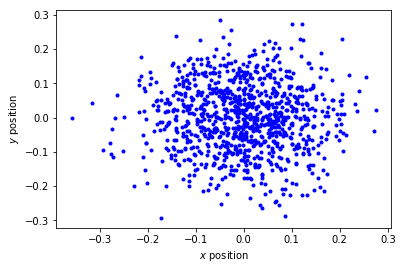

In [10]:
plt.plot(x_initial_samples[:,0], x_initial_samples[:,1], 'b.')
plt.xlabel(x_names_long[0])
plt.ylabel(x_names_long[1])
plt.show()

Define a function that generates samples of the state $\mathbf{X}_t$ given $\mathbf{X}_{t-1}$.

In [11]:
x_bar_x_prev_covariance = np.diagflat(np.repeat(drift**2,2))

In [12]:
def x_bar_x_prev_sample(x_prev):
    return np.random.multivariate_normal(x_prev, x_bar_x_prev_covariance)

Generate 1,000 samples (with $\mathbf{X}_{t-1}$ chosen arbitrarily) to make sure they have the properties we expect.

In [13]:
time_start = time.clock()
x_bar_x_prev_samples = np.array([x_bar_x_prev_sample(np.array([0.1, -0.2])) for i in range(1000)])
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 0.172094219906


In [14]:
np.mean(x_bar_x_prev_samples, 0)

array([ 0.10193458, -0.19887875])

In [15]:
np.std(x_bar_x_prev_samples, 0)

array([ 0.10227463,  0.09913344])

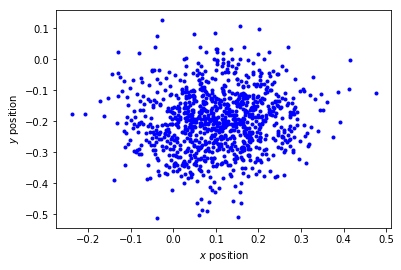

In [16]:
plt.plot(x_bar_x_prev_samples[:,0], x_bar_x_prev_samples[:,1], 'b.')
plt.xlabel(x_names_long[0])
plt.ylabel(x_names_long[1])
plt.show()

Define a function that returns the distances to the four sensors given $\mathbf{X}$.

In [17]:
def distances_to_sensors(x):
    return np.linalg.norm(np.tile(x,num_y_vars).reshape((num_y_vars, num_x_vars)) - sensor_positions, axis=1)

Try this out for a couple of values of $\mathbf{X}$ to make sure we get the results we expect.

In [18]:
distances_to_sensors(np.array([0, 0]))

array([ 1.41421356,  1.41421356,  1.41421356,  1.41421356])

In [19]:
math.sqrt(2)

1.4142135623730951

In [20]:
distances_to_sensors(np.array([-1, 0]))

array([ 1.        ,  1.        ,  2.23606798,  2.23606798])

In [21]:
math.sqrt(5)

2.23606797749979

Define a function that generates samples of the sensor readings $\mathbf{Y}$ given $\mathbf{X}$.

In [22]:
y_bar_x_covariance = np.diagflat(np.repeat(sensor_error**2,4))

In [23]:
def y_bar_x_sample(x):
    distances = distances_to_sensors(x)
    return np.random.multivariate_normal(distances, y_bar_x_covariance)

Generate 1,000 samples (with $\mathbf{X}$ chosen arbitrarily) to make sure they have the properties we expect.

In [24]:
time_start = time.clock()
y_bar_x_samples = np.array([y_bar_x_sample(np.array([-1, 0])) for i in range(1000)])
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 0.21651574762


In [25]:
np.mean(y_bar_x_samples, 0)

array([ 0.99798463,  1.00487051,  2.24551065,  2.23765019])

In [26]:
np.std(y_bar_x_samples, 0)

array([ 0.21026992,  0.19844963,  0.20268248,  0.19549664])

Define a generic Gaussian probability density function. We work with log-probabilities rather than probabilities to prevent underflow problems. We construct the Gaussian distribution from base Python operations rather than use the `scipy` PDF function because the latter was meaningfully slower in our tests.

In [27]:
def log_pdf_gaussian(x, mean, sd):
    return -(x-mean)**2/(2*sd**2) - math.log(math.sqrt(2*math.pi)*sd)

Plot the function to make sure it has the shape and normalization we expect.

In [28]:
x_range = np.arange(-10.0, 0.0, 0.01)

In [29]:
time_start = time.clock()
log_f_range = np.array([log_pdf_gaussian(x, -5.0, 1.0) for x in x_range])
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 0.00253695891756


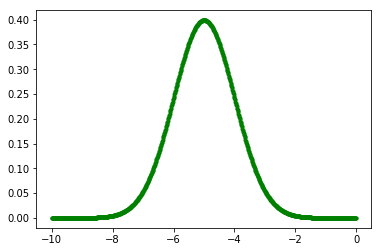

In [30]:
plt.plot(x_range, np.exp(log_f_range), 'g.')
plt.show()

Define $f(\mathbf{Y} | \mathbf{X})$, the probability density function for the sensor readings $\mathbf{Y}$ given the state $\mathbf{X}$.

In [31]:
def log_f_y_bar_x(x, y):
    distances = distances_to_sensors(x)
    log_probability_densities = np.array([log_pdf_gaussian(y[i], distances[i], sensor_error) for i in range(num_y_vars)])
    return np.sum(log_probability_densities)

Plot the dependence of $f(\mathbf{Y} | \mathbf{X})$ on the lower-left sensor reading, holding the values of all of the other sensor readings fixed, to make sure it has the shape we expect.

In [32]:
LL_range = np.arange(-2, 4, 0.01)

In [33]:
time_start = time.clock()
log_f_range = np.array([log_f_y_bar_x(np.array([0, 0]), np.array([LL, 1.4142, 1.4142, 1.4142])) for LL in LL_range])
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 0.0368631309384


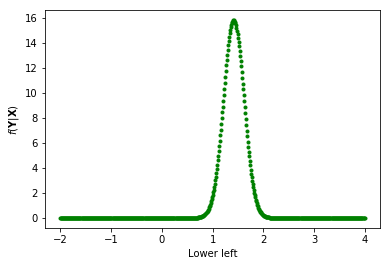

In [34]:
plt.plot(LL_range, np.exp(log_f_range), 'g.')
plt.xlabel(y_names_long[0])
plt.ylabel('$f(\mathbf{Y} | \mathbf{X})$')
plt.show()

Check to make sure that $f(\mathbf{Y} | \mathbf{X})$ is normalized properly by evaluating the crude numerical integral of the function over $\mathbf{Y}$

In [35]:
time_start = time.clock()
integral = 0
for LL in np.arange(0, 3, 0.1):
    print LL
    for UL in np.arange(0, 3, 0.1):
        for LR in np.arange(0, 3, 0.1):
            for UR in np.arange(0, 3, 0.1):
                integral = integral + math.exp(log_f_y_bar_x(np.array([0, 0]), np.array([LL, UL, LR, UR])))*0.0001
print'Time elapsed = {}'.format(time.clock()-time_start)
print 'Integral = {}'.format(integral)

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
Time elapsed = 38.9757568103
Integral = 0.999999999999


## Generate simulated $\mathbf{X}$ and $\mathbf{Y}$ data

Set the number of timesteps and initialize the variables.

In [36]:
num_timesteps = 100
t = np.zeros(num_timesteps, dtype='float')
x_t = np.zeros((num_timesteps, num_x_vars), dtype='float')
y_t = np.zeros((num_timesteps, num_y_vars), dtype='float')

Calculate the data for $t=0$.

In [37]:
t[0] = 0.0

In [38]:
x_t[0] = x_initial_sample()

In [39]:
y_t[0] = y_bar_x_sample(x_t[0])

Calculate the data for $t>0$.

In [40]:
timestep_size = 1.0

In [41]:
for t_index in range(1,num_timesteps):
    t[t_index] = t[t_index - 1] + timestep_size
    x_t[t_index] = x_bar_x_prev_sample(x_t[t_index - 1])
    y_t[t_index] = y_bar_x_sample(x_t[t_index])

Plot the data to make sure it has the properties we expect.

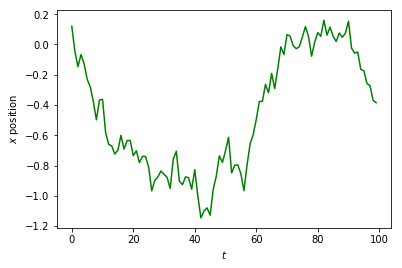

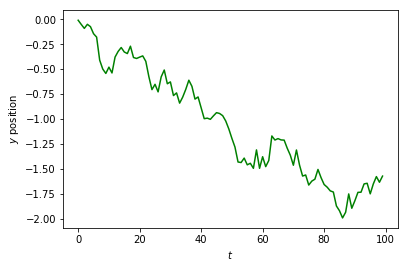

In [42]:
for x_var_index in range(num_x_vars):
    plt.plot(t, x_t[:, x_var_index], 'g-')
    plt.xlabel('$t$')
    plt.ylabel(x_names_long[x_var_index])
    plt.show()

In [43]:
distances_t = np.array([distances_to_sensors(x) for x in x_t])

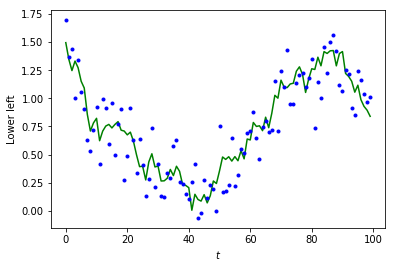

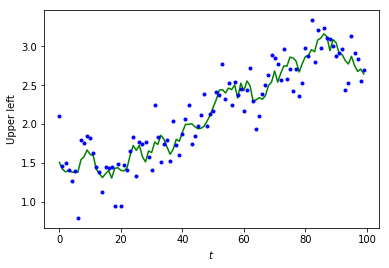

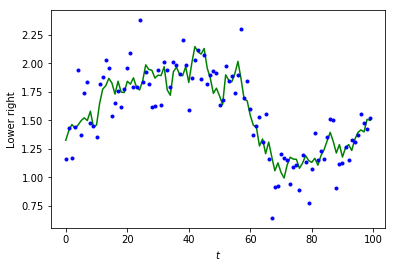

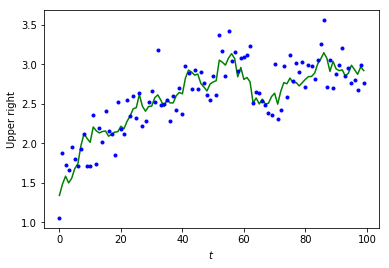

In [44]:
for y_var_index in range(num_y_vars):
    plt.plot(t, distances_t[:, y_var_index], 'g-')
    plt.plot(t, y_t[:, y_var_index], 'b.')
    plt.xlabel('$t$')
    plt.ylabel(y_names_long[y_var_index])
    plt.show()

## Sample the posterior distribution $f(\mathbf{X}_t | \mathbf{Y}_0, \mathbf{Y}_1, \ldots, \mathbf{Y}_t)$ using a particle filter

Set the number of particles and initialize variables.

In [45]:
num_particles = 50
particle_values = np.zeros((num_timesteps, num_particles, num_x_vars), dtype = 'float')
log_particle_weights = np.zeros((num_timesteps, num_particles), dtype = 'float')

Generate the particles for the initial state $\mathbf{X}_0$.

In [46]:
time_start = time.clock()
for particle_index in range(num_particles):
    particle_values[0, particle_index] = x_initial_sample()
    log_particle_weights[0, particle_index] = log_f_y_bar_x(particle_values[0, particle_index], y_t[0])
log_particle_weights[0] = log_particle_weights[0] - misc.logsumexp(log_particle_weights[0])
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 0.0241454830313


Check to see that these particles have the properties we expect.

In [47]:
math.exp(misc.logsumexp(log_particle_weights[0]))

1.0

In [48]:
x_initial_mean = np.average(particle_values[0], axis=0, weights = np.exp(log_particle_weights[0]))

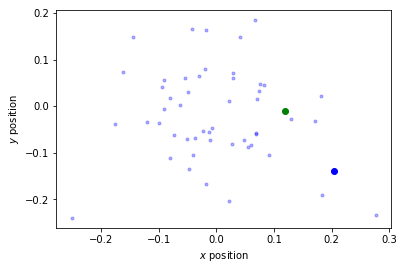

In [49]:
plt.plot(x_t[0,0],x_t[0,1],'go')
plt.plot(x_initial_mean[0], x_initial_mean[1], 'bo')
plt.plot(particle_values[0,:,0],particle_values[0,:,1], 'b.', alpha=0.3)
plt.xlabel(x_names_long[0])
plt.ylabel(x_names_long[1])
plt.show()

This looks as we expect. The particles are distributed according to the initial probability distribution (i.e., centered around $(0,0)$, not around the actual position of the particle). The weighted mean of the particles incorporates the sensor readings and so is closer to the actual position, but not on top of it due to both sensor error and sampling error. The real test is whether the particles converge and track the actual state as we generate successive sets of particles.

Calculate the particles for all times $t>0$.

In [50]:
time_start = time.clock()
for t_index in range(1, num_timesteps):
    for particle_index in range(num_particles):
        previous_particle = particle_values[t_index - 1,
                                            np.random.choice(num_particles,
                                                             p=np.exp(log_particle_weights[t_index - 1]))]
        particle_values[t_index, particle_index] = x_bar_x_prev_sample(previous_particle)
        log_particle_weights[t_index, particle_index] = log_f_y_bar_x(particle_values[t_index, particle_index], y_t[t_index])
    log_particle_weights[t_index] = log_particle_weights[t_index]- misc.logsumexp(log_particle_weights[t_index])
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 1.3454795326


Calculate the sample means and sample standard deviations of the particles at each time $t$.

In [51]:
x_mean_particle = np.average(
    particle_values, 
    axis=1, 
    weights=np.repeat(np.exp(log_particle_weights), 2).reshape((num_timesteps, num_particles, 2))
)

In [52]:
x_squared_mean_particle = np.average(
    np.square(particle_values), 
    axis=1, 
    weights=np.repeat(np.exp(log_particle_weights), 2).reshape((num_timesteps, num_particles, 2))
)

In [53]:
x_sd_particle = np.sqrt(x_squared_mean_particle - np.square(x_mean_particle))

Plot these sample means of the particles against the actual values of $\mathbf{X}_t$.

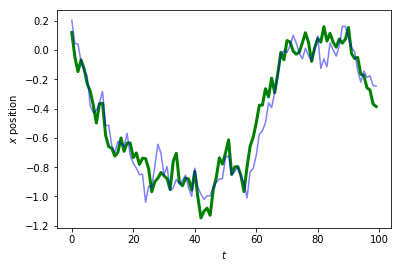

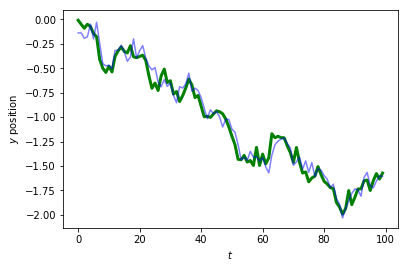

In [54]:
for x_var_index in range(num_x_vars):
    plt.plot(t, x_t[:,x_var_index], 'g-', linewidth=3.0)
    plt.plot(t, x_mean_particle[:,x_var_index], 'b-', alpha=0.5)
    plt.xlabel('$t$')
    plt.ylabel(x_names_long[x_var_index])
    plt.show()


Plot the sample confidence regions of the particles against the actual values of $\mathbf{X}_t$ (i.e., sample means plus/minus sample standard deviations)

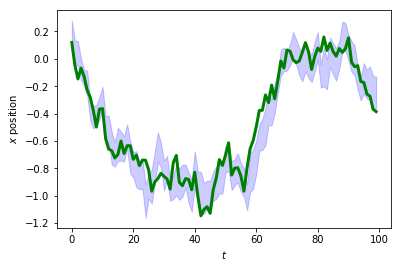

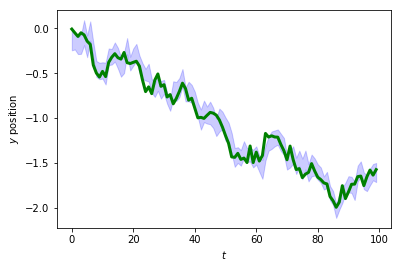

In [55]:
for x_var_index in range(num_x_vars):
    plt.fill_between(
        t,
        x_mean_particle[:,x_var_index] - x_sd_particle[:, x_var_index],
        x_mean_particle[:,x_var_index] + x_sd_particle[:, x_var_index],
        color='blue',
        alpha=0.2
    )
    plt.plot(t, x_t[:,x_var_index], 'g-', linewidth=3.0)
    plt.xlabel('$t$')
    plt.ylabel(x_names_long[x_var_index])
    plt.show()


The particle filter tracks extremely well, even with only 50 particles.